<a href="https://colab.research.google.com/github/HenryZumaeta/DataScienceMasters/blob/main/CICLO03/MLOPS/MLops_P01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices - Advanced Regression Techniques

Link del dataset:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [ ]:
# 1. Importación de librerías y configuración inicial

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from google.cloud import storage
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 2. Carga y exploración del dataset

# Carga del dataset
df = pd.read_csv("train.csv")
print("Dimensiones del dataset:", df.shape)
print(df.head())

# Mostrar cantidad de valores nulos
print("\nValores nulos en cada columna:")
print(df.isnull().sum())


Dimensiones del dataset: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleConditio

In [ ]:
# 3. Preparación y limpieza de los datos

# Eliminar columna 'Id'
if 'Id' in df.columns:
    df.drop('Id', axis=1, inplace=True)

# Imputar valores faltantes en columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Identificar columnas categóricas y aplicar one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Mostrar dimensiones
print("\nDimensiones del dataset después de la limpieza y codificación:", df.shape)



Dimensiones del dataset después de la limpieza y codificación: (1460, 245)


In [ ]:
# 4. División del dataset en variables predictoras y objetivo
# La variable objetivo es "SalePrice". Se separa el dataset en "X" (features) e "y" (target).

X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# División en conjuntos de entrenamiento y prueba (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)


Dimensiones de X_train: (1022, 244)
Dimensiones de X_test: (438, 244)


In [ ]:
# 5. Entrenamiento del modelo

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

RMSE: 42128.94900397957
R²: 0.7456542710682921


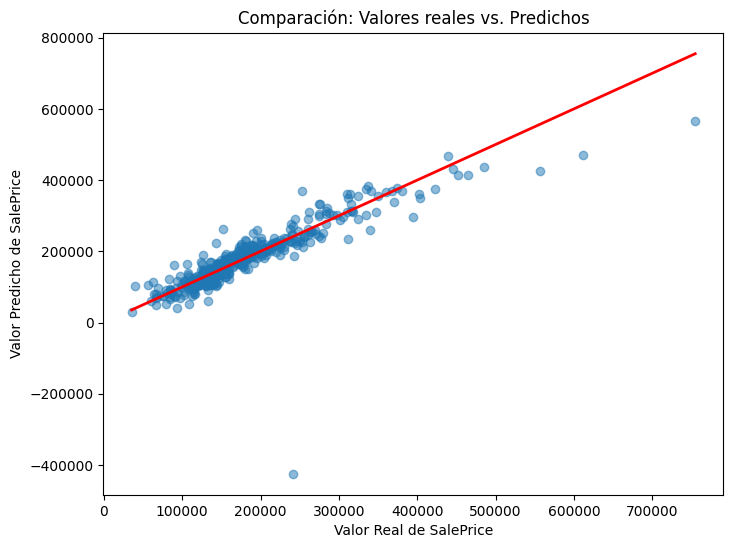

In [ ]:
# 6. Evaluación del modelo y gráfica
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

# Gráfica de predicciones vs. valores reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valor Real de SalePrice")
plt.ylabel("Valor Predicho de SalePrice")
plt.title("Comparación: Valores reales vs. Predichos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.show()

In [ ]:
# 7. Guardado del modelo entrenado y subida a Google Cloud Storage (GCS)

FILE_NAME = "model.joblib"
joblib.dump(lr, FILE_NAME)
print("Modelo guardado localmente como:", FILE_NAME)

# Configurar variables para GCS
BUCKET_NAME = "bucketzumaeta"
BLOB_PATH = "house_prices_model/"
BLOB_NAME = BLOB_PATH + FILE_NAME

# Subir el archivo a GCS
bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)
print("Modelo subido a GCS en:", f"gs://{BUCKET_NAME}/{BLOB_NAME}")

Modelo guardado localmente como: model.joblib
Modelo subido a GCS en: gs://bucketzumaeta/house_prices_model/model.joblib


In [ ]:
# 8. Publicación del modelo en Vertex AI

REGION = "us-west2"
MODEL_DISPLAY_NAME = "house-prices-linear-regression-model"
ARTIFACT_GCS_PATH = f"gs://{BUCKET_NAME}/{BLOB_PATH}"

# Comando para subir el modelo a Vertex AI
get_ipython().system(f'''
gcloud beta ai models upload \
  --region={REGION} \
  --display-name={MODEL_DISPLAY_NAME} \
  --container-image-uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-5:latest" \
  --artifact-uri={ARTIFACT_GCS_PATH}
''')

# Verificar la subida del modelo listándolo
get_ipython().system(f'gcloud beta ai models list --region {REGION} --filter=display_name={MODEL_DISPLAY_NAME}')

Using endpoint [https://us-west2-aiplatform.googleapis.com/]
Waiting for operation [3730924977776492544]...done.                            
Using endpoint [https://us-west2-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
2021122274177843200  house-prices-linear-regression-model


In [ ]:
MODEL_ID = "2021122274177843200"  # Reemplace este valor con el ID real del modelo obtenido

In [ ]:
# 9. Creación y despliegue del endpoint en Vertex AI

ENDPOINT_DISPLAY_NAME = "house-prices-linear-regression-endpoint"

# Crear el endpoint
get_ipython().system(f'''
gcloud beta ai endpoints create \
  --region={REGION} \
  --display-name={ENDPOINT_DISPLAY_NAME}
''')

# Listar endpoints para obtener el ENDPOINT_ID
get_ipython().system(f'gcloud beta ai endpoints list --region {REGION} --filter=display_name={ENDPOINT_DISPLAY_NAME}')

Using endpoint [https://us-west2-aiplatform.googleapis.com/]
Waiting for operation [2609528670561239040]...done.                            
Created Vertex AI endpoint: projects/436225358028/locations/us-west2/endpoints/2454826834777341952.
Using endpoint [https://us-west2-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
2454826834777341952  house-prices-linear-regression-endpoint


In [ ]:
ENDPOINT_ID = "2454826834777341952"

In [ ]:
# Desplegar el modelo en el endpoint
DEPLOYED_MODEL_NAME = "house-prices-linear-regression-v1"
MACHINE_TYPE = "n1-standard-2"

get_ipython().system(f'''
gcloud beta ai endpoints deploy-model {ENDPOINT_ID} \
  --region={REGION} \
  --model={MODEL_ID} \
  --display-name={DEPLOYED_MODEL_NAME} \
  --machine-type={MACHINE_TYPE} \
  --traffic-split=0=100
''')


Using endpoint [https://us-west2-aiplatform.googleapis.com/]
Waiting for operation [8738927763412484096]...done.                            
Deployed a model to the endpoint 2454826834777341952. Id of the deployed model: 8676215468454838272.


In [ ]:
# PREDICCIÓN DEL MODELO
from google.cloud import aiplatform

# Configurar variables del proyecto y endpoint
PROJECT_ID = "famous-tree-448915-m8"

# Construir la ruta completa del endpoint
endpoint = aiplatform.Endpoint(
    endpoint_name=f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
)

# Preparar una instancia para la predicción
example_instance = [float(x) for x in X_test.iloc[0].tolist()]
instances = [example_instance]

# Predicción
prediction = endpoint.predict(instances=instances)

print("Predicción recibida desde Vertex AI:")
print(prediction)

Predicción recibida desde Vertex AI:
Prediction(predictions=[158199.0504960761], deployed_model_id='8676215468454838272', metadata=None, model_version_id='1', model_resource_name='projects/436225358028/locations/us-west2/models/2021122274177843200', explanations=None)
